In [1]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.utils as np_utils
from keras.models import Sequential
from keras import models, layers
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# resources:
# https://engmrk.com/lenet-5-a-classic-cnn-architecture/
# https://keras.io/
# https://github.com/ryanleeallred/MNIST-convnet-gridsearch/blob/master/param_tuning.ipynb

Using TensorFlow backend.


In [2]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
x_test.shape

(10000, 28, 28)

In [6]:
y_train[0]

5

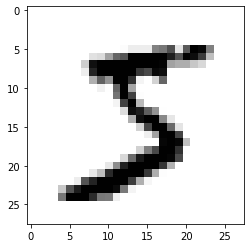

In [7]:
image = np.array(x_train[0], dtype='uint8')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray_r')

In [8]:
# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

In [9]:
def create_model(optimizer, activation_1, activation_2, activation_3, activation_4, kernel_size, pool_size, dropout_1, dropout_2):
    model = Sequential()
    # First convolutional layer
    model.add(layers.Conv2D(6, kernel_size=kernel_size, strides=(1, 1), activation=activation_1, input_shape=(28,28,1), padding="same"))

    # First pooling layer
    model.add(layers.AveragePooling2D(pool_size=pool_size, strides=(1, 1), padding='valid'))
    
    # Second convolutional layer
    model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation=activation_2, padding='valid'))
    
    # Second pooling layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    # Connected convolutional layer
    model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation=activation_3, padding='valid'))
    model.add(layers.Flatten())
    model.add(Dropout(dropout_1)) 
    # Connected layer
    model.add(layers.Dense(84, activation=activation_4))
    model.add(Dropout(dropout_2)) 
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # build/compile
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Nadam', metrics=["accuracy"])
    return model

In [8]:
#batch size
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [3],
              'batch_size': [10, 50, 100, 120, 200],
              'optimizer': ['SGD'],
              'activation_1' : ['tanh'],
              'activation_2' : ['tanh'],
              'activation_3' : ['tanh'],
              'activation_4' : ['tanh'],
              'kernel_size' : [[5,5]],
              'pool_size' : [[2,2]],
              'dropout_1' : [0.25],
              'dropout_2' : [0.25]
             }

my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH 120

Fitting 2 folds for each of 5 candidates, totalling 10 fits





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





30000/30000 [==============================] - 57s 2ms/step - loss: 0.5045 - acc: 0.8432
Epoch 2/3
30000/30000 [==============================] - 54s 2ms/step - loss: 0.3738 - acc: 0.8863
Epoch 3/3
30000/30000 [==============================] - 12s 405us/step
Epoch 1/3
30000/30000 [==============================] - 56s 2ms/step - loss: 0.4868 - acc: 0.8489
Epoch 2/3
30000/30000 [==============================] - 59s 2ms/step - loss: 0.3705 - acc: 0.8875
Epoch 3/3
30000/30000 [==============================] - 12s 405us/step
Epoch 1/3
30000/30000 [==============================] - 29s 979us/step - loss: 0.4108 - acc: 0.8751
Epoch 2/3
30000/30000 [==============================] - 27s 909us/step - loss: 0.3092 - acc: 0.9068
Epoch 3/3
30000/30000 [==============================] - 8s 272us/step
Epoch 1/3
30000/30000 [==============================] - 26s 858us/step - loss: 0.418

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 16.9min finished


Epoch 1/3
60000/60000 [==============================] - 47s 777us/step - loss: 0.3427 - acc: 0.8976
Epoch 2/3
60000/60000 [==============================] - 46s 774us/step - loss: 0.2414 - acc: 0.9273
Epoch 3/3
60000/60000 [==============================] - 45s 745us/step - loss: 0.1901 - acc: 0.9423
Best: 0.947733 using {'activation_1': 'tanh', 'activation_2': 'tanh', 'activation_3': 'tanh', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 3, 'kernel_size': [5, 5], 'optimizer': 'SGD', 'pool_size': [2, 2]}


NameError: name 'model' is not defined

In [12]:
#optimizer
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [3],
              'batch_size': [120],
              'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam', 'Adamax'],
              'activation_1' : ['tanh'],
              'activation_2' : ['tanh'],
              'activation_3' : ['tanh'],
              'activation_4' : ['tanh'],
              'kernel_size' : [[5,5]],
              'pool_size' : [[2,2]],
              'dropout_1' : [0.25],
              'dropout_2' : [0.25]
             }

my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH SIZE: 64
#BEST OPTIMIZER: NADAM

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
30000/30000 [==============================] - 23s 779us/step - loss: 0.2893 - acc: 0.9112
Epoch 2/3
30000/30000 [==============================] - 21s 701us/step - loss: 0.0869 - acc: 0.9739
Epoch 3/3
30000/30000 [==============================] - 7s 234us/step
Epoch 1/3
30000/30000 [==============================] - 24s 786us/step - loss: 0.2673 - acc: 0.9184
Epoch 2/3
30000/30000 [==============================] - 21s 717us/step - loss: 0.0703 - acc: 0.9789
Epoch 3/3
30000/30000 [==============================] - 7s 232us/step
Epoch 1/3
30000/30000 [==============================] - 24s 814us/step - loss: 0.2732 - acc: 0.9137
Epoch 2/3
30000/30000 [==============================] - 23s 768us/step - loss: 0.0760 - acc: 0.9762
Epoch 3/3
30000/30000 [==============================] - 7s 243us/step
Epoch 1/3
30000/30000 [==============================] - 23s 755us/step - loss: 0.3068 - acc: 0.9066
Epoch 2/3
30000/30000 [==============================] - 21s 704us/step - loss: 

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 17.5min finished


Epoch 1/3
60000/60000 [==============================] - 48s 793us/step - loss: 0.1751 - acc: 0.9461
Epoch 2/3
60000/60000 [==============================] - 46s 768us/step - loss: 0.0518 - acc: 0.9844
Epoch 3/3
60000/60000 [==============================] - 44s 737us/step - loss: 0.0375 - acc: 0.9882
Best: 0.986650 using {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 3, 'kernel_size': [5, 5], 'optimizer': 'Nadam', 'pool_size': [2, 2]}


In [10]:
#activations
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [2],
              'batch_size': [120],
              'optimizer': ['Nadam'],
              'activation_1' : ['relu', 'sigmoid', 'tanh'],
              'activation_2' : ['relu', 'sigmoid', 'tanh'],
              'activation_3' : ['relu', 'sigmoid', 'tanh'],
              'activation_4' : ['relu', 'sigmoid', 'tanh'],
              'kernel_size' : [[5,5]],
              'pool_size' : [[2,2]],
              'dropout_1' : [0.25],
              'dropout_2' : [0.25]
             }

my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH SIZE 120
#BEST OPTIMIZER Nadam
#BEST ACTIVATIONS tanh, relu, relu, tanh


Fitting 2 folds for each of 81 candidates, totalling 162 fits







[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/2





30000/30000 [==============================] - 32s 1ms/step - loss: 0.3068 - acc: 0.9061
Epoch 2/2
30000/30000 [==============================] - 7s 244us/step
Epoch 1/2
30000/30000 [==============================] - 28s 944us/step - loss: 0.2691 - acc: 0.9176
Epoch 2/2
30000/30000 [==============================] - 7s 223us/step
Epoch 1/2
30000/30000 [==============================] - 22s 742us/step - loss: 0.3370 - acc: 0.9051
Epoch 2/2
30000/30000 [==============================] - 7s 245us/step
Epoch 1/2
30000/30000 [==============================] - 29s 969us/step - loss: 0.3500 - acc: 0.9018
Epoch 2/2
30000/30000 [==============================] - 7s 221us/step
Epoch 1/2
30000/30000 [==============================] - 25s 842us/step - loss: 0.2273 - acc: 0

30000/30000 [==============================] - 35s 1ms/step - loss: 0.8855 - acc: 0.6967
Epoch 2/2
30000/30000 [==============================] - 9s 292us/step
Epoch 1/2
30000/30000 [==============================] - 26s 873us/step - loss: 0.7246 - acc: 0.7613
Epoch 2/2
30000/30000 [==============================] - 9s 288us/step
Epoch 1/2
30000/30000 [==============================] - 28s 937us/step - loss: 0.6164 - acc: 0.8063
Epoch 2/2
30000/30000 [==============================] - 9s 294us/step
Epoch 1/2
30000/30000 [==============================] - 28s 950us/step - loss: 2.3693 - acc: 0.10800s - loss: 2.3703 - acc: 
Epoch 2/2
30000/30000 [==============================] - 9s 288us/step
Epoch 1/2
30000/30000 [==============================] - 29s 981us/step - loss: 2.1251 - acc: 0.207110s - loss: 2.2621 - acc: - E
Epoch 2/2
30000/30000 [==============================] - 9s 290us/step
Epoch 1/2
30000/30000 [==============================] - 28s 941us/step - loss: 2.0728 - acc: 0.24

30000/30000 [==============================] - 40s 1ms/step - loss: 0.4001 - acc: 0.8910
Epoch 2/2
30000/30000 [==============================] - 9s 303us/step
Epoch 1/2
30000/30000 [==============================] - 30s 1ms/step - loss: 0.2615 - acc: 0.9205
Epoch 2/2
30000/30000 [==============================] - 12s 409us/step
Epoch 1/2
30000/30000 [==============================] - 34s 1ms/step - loss: 0.2490 - acc: 0.9241
Epoch 2/2
30000/30000 [==============================] - 10s 322us/step
Epoch 1/2
30000/30000 [==============================] - 30s 1ms/step - loss: 0.5384 - acc: 0.8248
Epoch 2/2
30000/30000 [==============================] - 12s 385us/step
Epoch 1/2
30000/30000 [==============================] - 33s 1ms/step - loss: 0.6885 - acc: 0.7706
Epoch 2/2
30000/30000 [==============================] - 9s 300us/step
Epoch 1/2
30000/30000 [==============================] - 28s 931us/step - loss: 0.6520 - acc: 0.7923
Epoch 2/2
30000/30000 [==============================] -

30000/30000 [==============================] - 11s 369us/step
Epoch 1/2
30000/30000 [==============================] - 33s 1ms/step - loss: 2.6424 - acc: 0.1013: 8s - los
Epoch 2/2
30000/30000 [==============================] - 11s 373us/step
Epoch 1/2
30000/30000 [==============================] - 34s 1ms/step - loss: 2.6207 - acc: 0.1045
Epoch 2/2
30000/30000 [==============================] - 12s 416us/step
Epoch 1/2
30000/30000 [==============================] - 35s 1ms/step - loss: 2.4100 - acc: 0.1076
Epoch 2/2
30000/30000 [==============================] - 11s 376us/step
Epoch 1/2
30000/30000 [==============================] - 33s 1ms/step - loss: 2.3954 - acc: 0.1107
Epoch 2/2
30000/30000 [==============================] - 12s 384us/step
Epoch 1/2
30000/30000 [==============================] - 37s 1ms/step - loss: 1.1090 - acc: 0.6230
Epoch 2/2
30000/30000 [==============================] - 14s 457us/step
Epoch 1/2
30000/30000 [==============================] - 35s 1ms/step - l

30000/30000 [==============================] - 41s 1ms/step - loss: 0.2296 - acc: 0.9289
Epoch 2/2
30000/30000 [==============================] - 14s 480us/step
Epoch 1/2
30000/30000 [==============================] - 42s 1ms/step - loss: 0.2045 - acc: 0.9361
Epoch 2/2
30000/30000 [==============================] - 14s 479us/step
Epoch 1/2
30000/30000 [==============================] - 45s 1ms/step - loss: 1.1618 - acc: 0.6427
Epoch 2/2
30000/30000 [==============================] - 14s 475us/step
Epoch 1/2
30000/30000 [==============================] - 43s 1ms/step - loss: 0.9788 - acc: 0.6917: 3s - loss: 
Epoch 2/2
30000/30000 [==============================] - 16s 546us/step
Epoch 1/2
30000/30000 [==============================] - 44s 1ms/step - loss: 0.5789 - acc: 0.8237
Epoch 2/2
30000/30000 [==============================] - 15s 496us/step
Epoch 1/2
30000/30000 [==============================] - 48s 2ms/step - loss: 0.6186 - acc: 0.8108
Epoch 2/2
30000/30000 [====================

30000/30000 [==============================] - 56s 2ms/step - loss: 2.6428 - acc: 0.1021
Epoch 2/2
30000/30000 [==============================] - 20s 677us/step
Epoch 1/2
30000/30000 [==============================] - 57s 2ms/step - loss: 0.2509 - acc: 0.9241
Epoch 2/2
30000/30000 [==============================] - 19s 627us/step
Epoch 1/2
30000/30000 [==============================] - 57s 2ms/step - loss: 0.2474 - acc: 0.9243
Epoch 2/2
30000/30000 [==============================] - 19s 645us/step
Epoch 1/2
30000/30000 [==============================] - 58s 2ms/step - loss: 0.2918 - acc: 0.9190
Epoch 2/2
30000/30000 [==============================] - 21s 687us/step
Epoch 1/2
30000/30000 [==============================] - 57s 2ms/step - loss: 0.3055 - acc: 0.9172
Epoch 2/2
30000/30000 [==============================] - 17s 566us/step
Epoch 1/2
30000/30000 [==============================] - 48s 2ms/step - loss: 0.2136 - acc: 0.9338
Epoch 2/2
30000/30000 [==============================] -

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 222.6min finished


Epoch 1/2
60000/60000 [==============================] - 77s 1ms/step - loss: 0.1467 - acc: 0.9543
Epoch 2/2
60000/60000 [==============================] - 59s 984us/step - loss: 0.0474 - acc: 0.9856
Best: 0.983333 using {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 2, 'kernel_size': [5, 5], 'optimizer': 'Nadam', 'pool_size': [2, 2]}
0.983100 (0.001367) with: {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 2, 'kernel_size': [5, 5], 'optimizer': 'Nadam', 'pool_size': [2, 2]}
0.981167 (0.000600) with: {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'sigmoid', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 2, 'kernel_size': [5, 5], 'optimizer': 'Nadam', 'pool_size': [2, 2]}
0.982650 (0.000217) with:

10000/10000 [==============================] - 14s 1ms/step
Test Accuracy 0.9882000062465668


In [11]:
#kernel size
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [3],
              'batch_size': [120],
              'optimizer': ['Nadam'],
              'activation_1' : ['tanh'],
              'activation_2' : ['relu'],
              'activation_3' : ['relu'],
              'activation_4' : ['tanh'],
              'kernel_size' : [[3,3], [4,4], [5,5]],
              'pool_size' : [[2,2]],
              'dropout_1' : [0.25],
              'dropout_2' : [0.25]
             }

my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH SIZE 120
#BEST OPTIMIZER Nadam
#BEST ACTIVATIONS tanh, relu, relu, tanh


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
30000/30000 [==============================] - 54s 2ms/step - loss: 0.2527 - acc: 0.9246
Epoch 2/3
30000/30000 [==============================] - 26s 871us/step - loss: 0.0674 - acc: 0.9795
Epoch 3/3
30000/30000 [==============================] - 17s 577us/step
Epoch 1/3
30000/30000 [==============================] - 50s 2ms/step - loss: 0.2119 - acc: 0.9360
Epoch 2/3
30000/30000 [==============================] - 26s 861us/step - loss: 0.0561 - acc: 0.9829
Epoch 3/3
30000/30000 [==============================] - 18s 589us/step
Epoch 1/3
30000/30000 [==============================] - 50s 2ms/step - loss: 0.2103 - acc: 0.9345
Epoch 2/3
30000/30000 [==============================] - 26s 867us/step - loss: 0.0648 - acc: 0.9806
Epoch 3/3
30000/30000 [==============================] - 18s 611us/step
Epoch 1/3
30000/30000 [==============================] - 52s 2ms/step - loss: 0.2170 - acc: 0.9339: 3s - loss: 0.2258
Epoch 2/3
30000/30000 [==============================] - 26s 881us

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.3min finished


Epoch 1/3
60000/60000 [==============================] - ETA: 0s - loss: 0.1395 - acc: 0.957 - 76s 1ms/step - loss: 0.1393 - acc: 0.9579
Epoch 2/3
60000/60000 [==============================] - 52s 866us/step - loss: 0.0487 - acc: 0.9848
Epoch 3/3
60000/60000 [==============================] - 52s 861us/step - loss: 0.0359 - acc: 0.9890
Best: 0.986400 using {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 3, 'kernel_size': [4, 4], 'optimizer': 'Nadam', 'pool_size': [2, 2]}
0.985950 (0.000683) with: {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.25, 'dropout_2': 0.25, 'epochs': 3, 'kernel_size': [3, 3], 'optimizer': 'Nadam', 'pool_size': [2, 2]}
0.986400 (0.001067) with: {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropo

In [12]:
#pool size
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [3],
              'batch_size': [120],
              'optimizer': ['Nadam'],
              'activation_1' : ['tanh'],
              'activation_2' : ['relu'],
              'activation_3' : ['relu'],
              'activation_4' : ['tanh'],
              'kernel_size' : [[4,4]],
              'pool_size' : [[1,1], [2,2]],
              'dropout_1' : [0.0],
              'dropout_2' : [0.0]
             }

my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH SIZE 120
#BEST OPTIMIZER Nadam

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/3
30000/30000 [==============================] - 54s 2ms/step - loss: 0.1788 - acc: 0.9440
Epoch 2/3
30000/30000 [==============================] - 26s 882us/step - loss: 0.0474 - acc: 0.9849
Epoch 3/3
30000/30000 [==============================] - 18s 601us/step
Epoch 1/3
30000/30000 [==============================] - 51s 2ms/step - loss: 0.1776 - acc: 0.9472
Epoch 2/3
30000/30000 [==============================] - 26s 877us/step - loss: 0.0431 - acc: 0.9872
Epoch 3/3
30000/30000 [==============================] - 18s 599us/step
Epoch 1/3
30000/30000 [==============================] - 51s 2ms/step - loss: 0.1835 - acc: 0.9423
Epoch 2/3
30000/30000 [==============================] - 26s 872us/step - loss: 0.0474 - acc: 0.9860
Epoch 3/3
30000/30000 [==============================] - 18s 604us/step
Epoch 1/3
30000/30000 [==============================] - 49s 2ms/step - loss: 0.1943 - acc: 0.9389- ETA: 1s - loss: 0.1996 - ac
Epoch 2/3
30000/30000 [==============================] -

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.1min finished


Epoch 1/3
60000/60000 [==============================] - 78s 1ms/step - loss: 0.1136 - acc: 0.9648
Epoch 2/3
60000/60000 [==============================] - 52s 862us/step - loss: 0.0338 - acc: 0.9893
Epoch 3/3
60000/60000 [==============================] - 52s 863us/step - loss: 0.0223 - acc: 0.9932
Best: 0.985667 using {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.0, 'dropout_2': 0.0, 'epochs': 3, 'kernel_size': [4, 4], 'optimizer': 'Nadam', 'pool_size': [1, 1]}
0.985667 (0.000733) with: {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.0, 'dropout_2': 0.0, 'epochs': 3, 'kernel_size': [4, 4], 'optimizer': 'Nadam', 'pool_size': [1, 1]}
0.983400 (0.000033) with: {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'tanh', 'batch_size': 120, 'dropout_1': 0.0, 'dropout_2': 0.0, 'epochs': 3,

In [15]:
#dropouts
seed = 42
np.random.seed(seed)

param_grid = {'epochs': [2],
              'batch_size': [120],
              'optimizer': ['Nadam'],
              'activation_1' : ['tanh'],
              'activation_2' : ['relu'],
              'activation_3' : ['relu'],
              'activation_4' : ['tanh'],
              'kernel_size' : [[4,4]],
              'pool_size' : [[1,1]],
              'dropout_1' : [0.0, 0.25, 0.5, 0.75],
              'dropout_2' : [0.0, 0.25, 0.5, 0.75]
             }


my_classifier = KerasClassifier(create_model)

grid = GridSearchCV(my_classifier, param_grid, cv=2, n_jobs=1, verbose=1)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Print Test Accuracy
print("Test Accuracy", grid_result.score(x_test, y_test))
#BEST BATCH SIZE 120
#BEST OPTIMIZER Nadam

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
30000/30000 [==============================] - 110s 4ms/step - loss: 0.1808 - acc: 0.9440
Epoch 2/2
30000/30000 [==============================] - 43s 1ms/step
Epoch 1/2


KeyboardInterrupt: 

In [ ]:
cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min', baseline=None, restore_best_weights=True)
cb_list = [cb]
hist = model.fit(x=x_train,y=y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test), verbose=1)
test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))
#Test 1: all activations relu, 96.82% acc
#Test 2: first layer tanh, 96.75% acc
#Test 3: third layer tanh, 95.84% acc
#Test 4: fifth layer tanh, 95.39% acc
#Test 5: sixth layer tanh, 96.22% acc
#It seems that the most successful activation function is rectified linear unit, so I am sticking with relu for 1st, 3rd, 5th, and 6h layer.
#Test 6: Adadelta optimizer, 98.84% acc
#Test 7: Adamax optimizer, 99.04% acc
#Test 8: RMSprop optimizer, 99.03% acc
#Test 9: Adagrad optimizer, 98.95% acc
#Test 10: Adam optimizer, 99.01% acc
#Test 11: Nadam optimizer, 99.15% acc <----

In [ ]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['acc'], 'o-')
ax.plot([None] + hist.history['val_acc'], 'x-')
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

In [ ]:
f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')
ax.legend(['Train Loss', 'Validation Loss'], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')